In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions


In [6]:
!kaggle datasets download tpapp157/earth-terrain-height-and-segmentation-map-images -p /content/data/ --unzip


Dataset URL: https://www.kaggle.com/datasets/tpapp157/earth-terrain-height-and-segmentation-map-images
License(s): unknown
100% 3.25G/3.25G [02:29<00:00, 22.6MB/s]
100% 3.25G/3.25G [02:29<00:00, 23.3MB/s]


In [7]:
img = []
mask = []
direc = '/content/data/'

In [8]:
images_dir = []
images_dir = sorted(os.listdir(direc))
print(len(images_dir))

for i in images_dir:
    if 'i2' in i:
        mask.append(i)
    if 't' in i:
        img.append(i)

15000


In [9]:
img

['0001_t.png',
 '0002_t.png',
 '0003_t.png',
 '0004_t.png',
 '0005_t.png',
 '0006_t.png',
 '0007_t.png',
 '0008_t.png',
 '0009_t.png',
 '0010_t.png',
 '0011_t.png',
 '0012_t.png',
 '0013_t.png',
 '0014_t.png',
 '0015_t.png',
 '0016_t.png',
 '0017_t.png',
 '0018_t.png',
 '0019_t.png',
 '0020_t.png',
 '0021_t.png',
 '0022_t.png',
 '0023_t.png',
 '0024_t.png',
 '0025_t.png',
 '0026_t.png',
 '0027_t.png',
 '0028_t.png',
 '0029_t.png',
 '0030_t.png',
 '0031_t.png',
 '0032_t.png',
 '0033_t.png',
 '0034_t.png',
 '0035_t.png',
 '0036_t.png',
 '0037_t.png',
 '0038_t.png',
 '0039_t.png',
 '0040_t.png',
 '0041_t.png',
 '0042_t.png',
 '0043_t.png',
 '0044_t.png',
 '0045_t.png',
 '0046_t.png',
 '0047_t.png',
 '0048_t.png',
 '0049_t.png',
 '0050_t.png',
 '0051_t.png',
 '0052_t.png',
 '0053_t.png',
 '0054_t.png',
 '0055_t.png',
 '0056_t.png',
 '0057_t.png',
 '0058_t.png',
 '0059_t.png',
 '0060_t.png',
 '0061_t.png',
 '0062_t.png',
 '0063_t.png',
 '0064_t.png',
 '0065_t.png',
 '0066_t.png',
 '0067_t.p

In [10]:
md = pd.DataFrame({'Images':img,'Mask':mask},index=range(5000))


In [11]:
md.head(4)

,Images,Mask
0,0001_t.png,0001_i2.png
1,0002_t.png,0002_i2.png
2,0003_t.png,0003_i2.png
3,0004_t.png,0004_i2.png


In [12]:
img = []
mask = []
shape = (128,128)


df ={'Image' : [],'Mask' : []}

for i in tqdm(range(len(md))):
    i_dir = direc + md.loc[i][0]
    m_dir = direc + md.loc[i][1]
    t_i = plt.imread(i_dir)
    t_m = plt.imread(m_dir)
    df['Image'].append(cv2.resize(t_i, shape))
    df['Mask'].append(cv2.resize(t_m, shape))

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-12-b462ad092f50>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_dir = direc + md.loc[i][0]
<ipython-input-12-b462ad092f50>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m_dir = direc + md.loc[i][1]
100%|██████████| 5000/5000 [01:07<00:00, 74.46it/s]


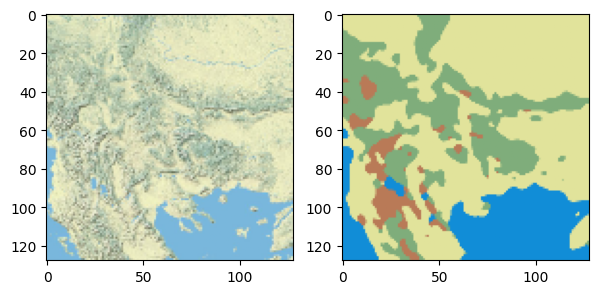

In [13]:
plt.figure(figsize = (7, 7))
plt.subplot(1,2,1)
plt.imshow(df['Image'][10])
plt.subplot(1,2,2)
plt.imshow(df['Mask'][10])
plt.show()

# Unet


In [14]:
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dropout, Dense, Activation, concatenate
import tensorflow as tf

#Block

def block(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True, k = 3):
    c1 = tf.keras.layers.Conv2D(numFilters*1,kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(inputImage)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    c1 = tf.keras.layers.Conv2D(numFilters*1,kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)

    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(0.1)(p1)

    c2 = tf.keras.layers.Conv2D(numFilters*2, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    c2 = tf.keras.layers.Conv2D(numFilters*2, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)

    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(0.1)(p2)

    c3 = tf.keras.layers.Conv2D(numFilters*4, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    c3 = tf.keras.layers.Conv2D(numFilters*4, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)

    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(0.1)(p3)

    c4 = tf.keras.layers.Conv2D(numFilters*8, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    c4 = tf.keras.layers.Conv2D(numFilters*8, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)

    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(0.1)(p4)

    c5 = tf.keras.layers.Conv2D(numFilters*16, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    c5 = tf.keras.layers.Conv2D(numFilters*16,kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)

    c6 = tf.keras.layers.Conv2D(numFilters*8, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)
    c6 = tf.keras.layers.Conv2D(numFilters*8, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)


    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)

    c7 = tf.keras.layers.Conv2D(numFilters*4, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)
    c7 = tf.keras.layers.Conv2D(numFilters*4, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)

    c8 = tf.keras.layers.Conv2D(numFilters*2, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)
    c8 = tf.keras.layers.Conv2D(numFilters*2, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)


    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)

    c9 = tf.keras.layers.Conv2D(numFilters*2, kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)
    c9 = tf.keras.layers.Conv2D(numFilters*2,kernel_size=(k,k),kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)



    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])


    return model

In [15]:
inputs = tf.keras.layers.Input((128, 128, 3))

myTransformer = block(inputs, droupouts= 0.07)

myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [16]:
retVal = myTransformer.fit(np.array(df['Image']), np.array(df['Mask']), epochs = 50, verbose = 1)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 212ms/step - accuracy: 0.7135 - loss: 0.5963
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.8141 - loss: 0.5647
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8219 - loss: 0.5609
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.8334 - loss: 0.5595
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.8462 - loss: 0.5598
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8489 - loss: 0.5585
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8545 - loss: 0.5570
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.8542 - loss: 0.5578
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.8571 - loss: 0.5567
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8547 - loss: 0.5560
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.8631 - loss: 0.5557
Epoch 12/50
157/157 ━━━━━━━━━

In [17]:
myTransformer.save('TerrainMaskGenerator.keras')


In [18]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['Image']
    mask = valMap['Mask']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Terrain Image')

    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 16, -1], [-1, -1, -1]])
    imgSharpen = cv2.filter2D(predMask,-1,filter)

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Terrain Mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Terrain Mask')

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


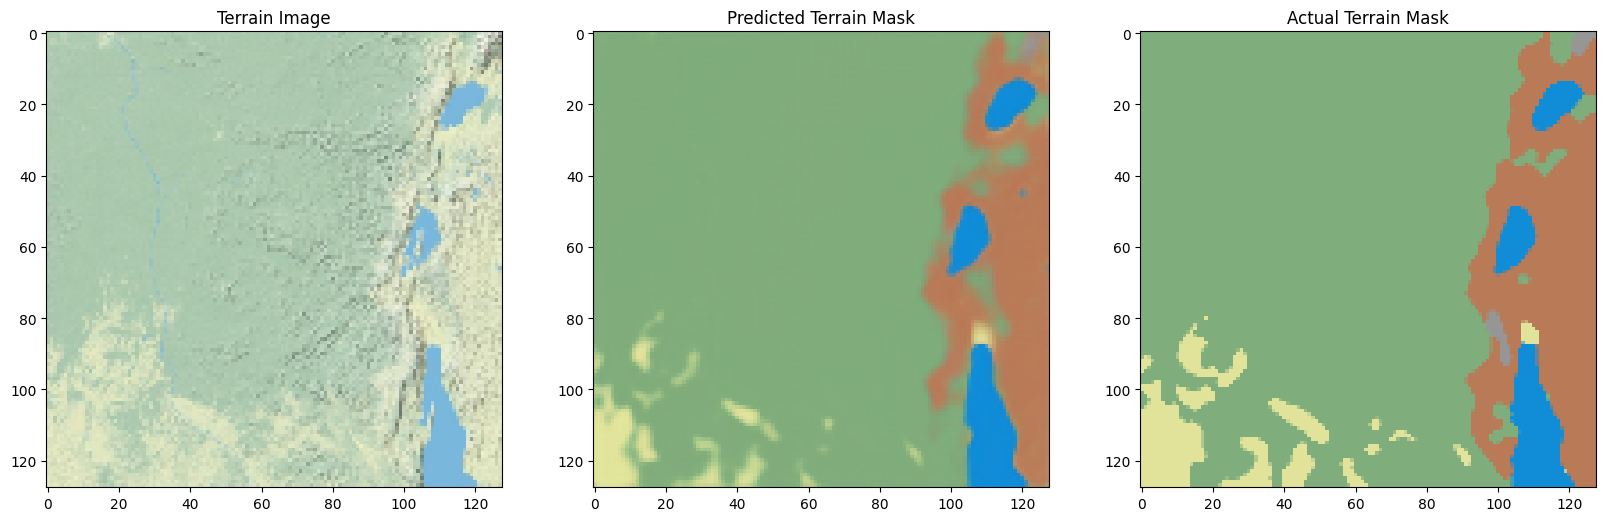

In [19]:
sixteenPrediction, actuals, masks = predict16(df, myTransformer)
Plotter(actuals[1], sixteenPrediction[1], masks[1])

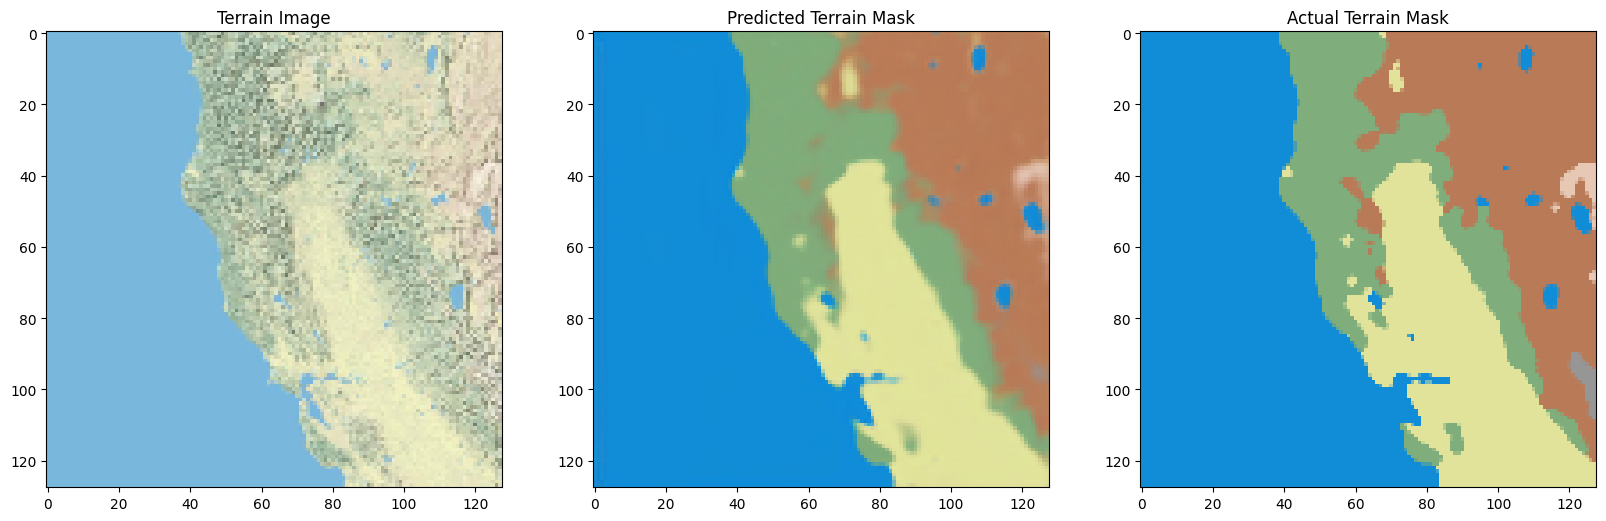

In [20]:
Plotter(actuals[0], sixteenPrediction[0], masks[0])


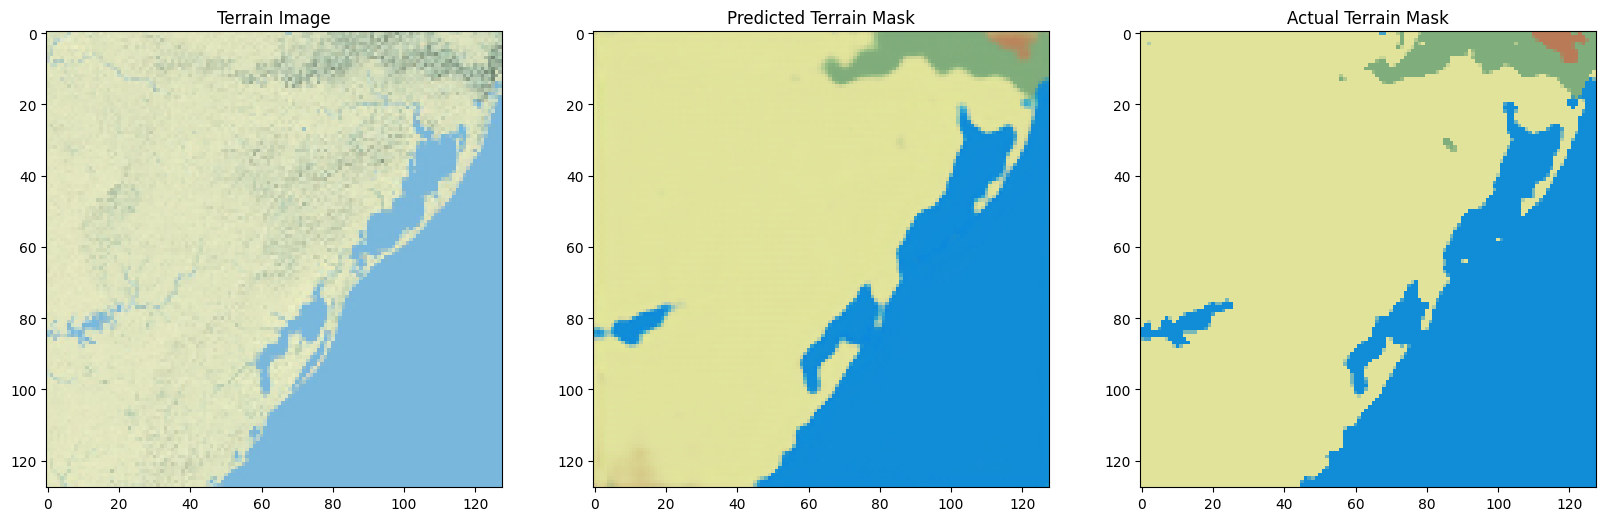

In [21]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])
